
--- [1/4] Loading and Preparing Data ---
Memory usage: 88.8% (Free: 0.92GB)
Loading data from C:/Users/dines/datasets/nordpool_se4_with_temperature.csv
Raw data shape: (46629, 4)
Data range: 2020-01-01 00:00:00 to 2025-04-23 23:00:00
Ensuring continuous data...
Converting to UTC...

Data sample:
                            Price  Exogenous 1  Exogenous 2
2020-01-01 01:00:00+00:00  296.96        768.0          1.9
2020-01-01 02:00:00+00:00  291.22        552.0          2.0
2020-01-01 03:00:00+00:00  287.25        403.0          2.2
2020-01-01 04:00:00+00:00  287.46        224.0          2.4
2020-01-01 05:00:00+00:00  277.13         45.0          2.6

Total hours: 46559

--- [2/4] Configuring Models ---

Evaluation period: 2025-01-01 to 2025-04-15
In-sample data size: 43847 hours (1827.0 days)

--- [3/4] Evaluating Models ---

Evaluating LEAR_364d with exogenous: ['NetLoad', 'Temperature']


LEAR_364d Progress: 100%|██████████| 105/105 [3:08:35<00:00, 107.77s/it, avg_time=107.76s, remaining=0.0min]     



Evaluating LEAR_728d with exogenous: ['NetLoad', 'Temperature']


LEAR_728d Progress: 100%|██████████| 105/105 [09:25<00:00,  5.38s/it, avg_time=5.38s, remaining=0.0min]



Evaluating LEAR_1092d with exogenous: ['NetLoad', 'Temperature']


LEAR_1092d Progress: 100%|██████████| 105/105 [1:27:56<00:00, 50.25s/it, avg_time=50.25s, remaining=0.0min]   



--- [4/4] Results ---

Model Performance Metrics:
                MAE  MAE_sigma     RMSE   sMAPE   rMAE
LEAR_364d   253.254      0.270  380.435  48.474  0.421
LEAR_728d   242.127      0.258  362.243  46.597  0.402
LEAR_1092d  245.340      0.262  361.384  47.974  0.407

Performance Analysis:

LEAR_364d:
  MAE: 253.25 SEK/MWh
  Relative MAE: 0.270 (in std units)
  RMSE: 380.44 SEK/MWh
  sMAPE: 48.47%
  rMAE: 0.421

LEAR_728d:
  MAE: 242.13 SEK/MWh
  Relative MAE: 0.258 (in std units)
  RMSE: 362.24 SEK/MWh
  sMAPE: 46.60%
  rMAE: 0.402

LEAR_1092d:
  MAE: 245.34 SEK/MWh
  Relative MAE: 0.262 (in std units)
  RMSE: 361.38 SEK/MWh
  sMAPE: 47.97%
  rMAE: 0.407

Execution Times:
LEAR_364d:
  Total time: 11315.17 seconds
  Average per day: 107.76 seconds
  Days evaluated: 105
LEAR_728d:
  Total time: 565.02 seconds
  Average per day: 5.38 seconds
  Days evaluated: 105
LEAR_1092d:
  Total time: 5275.86 seconds
  Average per day: 50.25 seconds
  Days evaluated: 105

Saved forecast plot as 'p

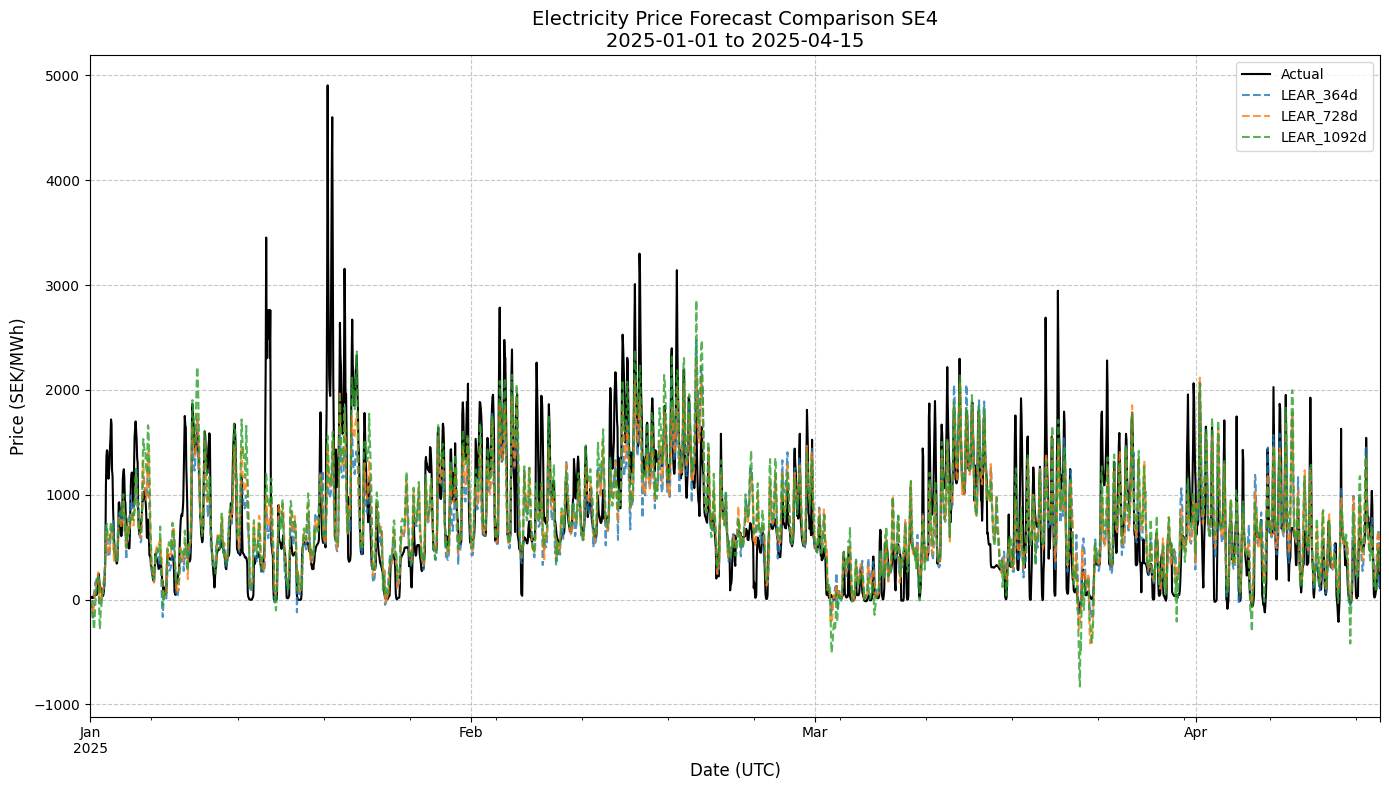


--- Script Completed ---


In [1]:
# ======================================================================
# 1. Imports and Environment Setup
# ======================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from epftoolbox.models import LEAR
from epftoolbox.evaluation import MAE, sMAPE, RMSE
import warnings, os, logging, psutil, traceback, time
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def check_memory():
    mem = psutil.virtual_memory()
    print(f"Memory usage: {mem.percent}% (Free: {mem.available/1e9:.2f}GB)")

# ======================================================================
# 2. Data Cleaning Helper Functions
# ======================================================================
def clean_column_names(df):
    """Standardize and rename key columns for consistent access."""
    df.columns = [str(c).replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]
    rename_map = {
        'Nord_Pool_Spot_Price_SE3_SEK_MWh': 'Price',
        'Consumption_SE3_MWh': 'Consumption',
        'Production_SE3_MWh': 'Production',
        'Temperature': 'Temperature'
    }
    for k in list(rename_map.keys()):
        if k not in df.columns:
            del rename_map[k]
    return df.rename(columns=rename_map)

def robust_rMAE(actual, forecast, p_in_sample):
    """Custom rMAE implementation that avoids division errors and checks edge cases."""
    try:
        actual = np.array(actual).flatten()
        forecast = np.array(forecast).flatten()
        p_in_sample = np.array(p_in_sample).flatten()
        mae_model = MAE(actual, forecast)
        if len(p_in_sample) < 7*24:
            print("Warning: Not enough in-sample data for rMAE (need 7 days)")
            return np.nan
        last_week = p_in_sample[-7*24:]
        n_repeats = (len(actual) // (7*24)) + 1
        naive_forecast = np.tile(last_week, n_repeats)[:len(actual)]
        mae_naive = MAE(actual, naive_forecast)
        if mae_naive < 1e-10:
            print("Warning: Naive forecast MAE is zero - rMAE undefined")
            return np.nan
        return mae_model / mae_naive
    except Exception as e:
        print(f"rMAE calculation error: {str(e)}")
        return np.nan

def evaluate_model_metrics(forecast, actual, p_in_sample):
    """Calculate MAE, RMSE, sMAPE, sigma-scaled MAE, and robust rMAE."""
    try:
        actual_arr = actual.values.astype(float)
        forecast_arr = forecast.values.astype(float)
        p_in_sample_arr = p_in_sample.values.astype(float)
        mae = MAE(actual_arr, forecast_arr)
        rmse = RMSE(actual_arr, forecast_arr)
        smape = sMAPE(actual_arr, forecast_arr) * 100
        sigma_p = np.std(p_in_sample_arr)
        mae_sigma = mae / sigma_p if sigma_p > 0 else np.nan
        rmae_val = robust_rMAE(actual_arr, forecast_arr, p_in_sample_arr)
        return {
            'MAE': np.round(mae, 3),
            'MAE_sigma': np.round(mae_sigma, 3),
            'RMSE': np.round(rmse, 3),
            'sMAPE': np.round(smape, 3),
            'rMAE': np.round(rmae_val, 3)
        }
    except Exception as e:
        print(f"Error in metrics calculation: {str(e)}")
        return {k: np.nan for k in ['MAE', 'MAE_sigma', 'RMSE', 'sMAPE', 'rMAE']}

def handle_dst_transitions(df):
    """Ensure data is continuous over DST transitions by interpolating missing hours."""
    df = df[~df.index.duplicated(keep='first')]
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
    df = df.reindex(full_index)
    return df.interpolate(method='time')

# ======================================================================
# 3. Main Script: Data Preparation and Model Evaluation
# ======================================================================
try:
    # ----- Load and Prepare Data -----
    print("--- [1/4] Loading and Preparing Data ---")
    check_memory()
    FILE_PATH = 'C:/Users/dines/datasets/nordpool_se4_with_temperature.csv'
    print(f"Loading data from {FILE_PATH}")
    df = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)
    df.index.name = 'Datetime'
    print(f"Raw data shape: {df.shape}")
    print(f"Data range: {df.index.min()} to {df.index.max()}")

    # Clean and extract
    df = clean_column_names(df)
    if not all(x in df.columns for x in ['Price', 'Consumption', 'Production']):
        raise Exception("File must include Price, Consumption, and Production columns!")

    # -- Create Net Load (Consumption - Production) --
    df['NetLoad'] = df['Consumption'] - df['Production']

    # -- Handle Temperature if exists --
    exog_vars = ['NetLoad']
    if 'Temperature' in df.columns:
        exog_vars.append('Temperature')

    # Build columns to use
    use_cols = ['Price'] + exog_vars
    df = df[use_cols].copy()

    print("Ensuring continuous data...")
    df = handle_dst_transitions(df)
    print("Converting to UTC...")
    if df.index.tz is None:
        df = df.tz_localize('UTC', ambiguous='NaT', nonexistent='shift_forward')
    else:
        df = df.tz_convert('UTC')
    df = df.dropna()
    
    # -- Rename exogenous columns for epftoolbox --
    exog_map = {'NetLoad': 'Exogenous 1'}
    if 'Temperature' in exog_vars:
        exog_map['Temperature'] = 'Exogenous 2'
    df_toolbox = df.rename(columns=exog_map)

    print("\nData sample:")
    print(df_toolbox.head())
    print(f"\nTotal hours: {len(df_toolbox)}")

    # ----- Set up models with different calibration window sizes -----
    print("\n--- [2/4] Configuring Models ---")
    models_to_eval = {
        'LEAR_364d':   {'cal_window': 364},
        'LEAR_728d':   {'cal_window': 728},
        'LEAR_1092d':  {'cal_window': 1092}
    }

    # ----- Define the evaluation period -----
    eval_start = pd.Timestamp('2025-01-01', tz='UTC')
    eval_end   = pd.Timestamp('2025-04-15', tz='UTC')
    print(f"\nEvaluation period: {eval_start.date()} to {eval_end.date()}")
    p_in_sample = df_toolbox.loc[:eval_start - pd.Timedelta(hours=1), 'Price']
    print(f"In-sample data size: {len(p_in_sample)} hours ({len(p_in_sample)/24:.1f} days)")

    # ----- Model evaluation loop -----
    print("\n--- [3/4] Evaluating Models ---")
    all_forecasts = {}
    all_metrics = {}
    execution_times = {}

    for model_name, model_info in models_to_eval.items():
        print(f"\nEvaluating {model_name} with exogenous: {exog_vars}")
        daily_forecasts = []
        test_days = pd.date_range(start=eval_start, end=eval_end, freq='D', tz='UTC')
        model_exec_times = []
        progress_bar = tqdm(total=len(test_days), desc=f"{model_name} Progress")
        for i, day in enumerate(test_days):
            start_time = time.time()
            try:
                model = LEAR()
                pred = model.recalibrate_and_forecast_next_day(
                    df=df_toolbox,
                    next_day_date=day,
                    calibration_window=model_info['cal_window']
                )
                pred = np.array(pred).flatten()
                if len(pred) == 0:
                    raise ValueError("Empty prediction array")
                elif len(pred) == 1:
                    pred = np.full(24, pred[0])
                elif len(pred) < 24:
                    last_val = pred[-1]
                    pred = np.pad(pred, (0, 24-len(pred)), 'constant', constant_values=last_val)
                elif len(pred) > 24:
                    pred = pred[:24]
                idx = pd.date_range(start=day, periods=24, freq='h', tz='UTC')
                forecast_series = pd.Series(pred, index=idx, name='Forecast', dtype=float)
                daily_forecasts.append(forecast_series)
            except Exception as e:
                print(f"\nError on {day.date()}: {str(e)}")
                traceback.print_exc()
            elapsed = time.time() - start_time
            model_exec_times.append(elapsed)
            avg_time = np.mean(model_exec_times)
            remaining = (len(test_days) - i - 1) * avg_time
            progress_bar.set_postfix({'avg_time': f"{avg_time:.2f}s", 'remaining': f"{remaining/60:.1f}min"})
            progress_bar.update(1)
        progress_bar.close()
        execution_times[model_name] = {
            'total': np.sum(model_exec_times),
            'avg_per_day': np.mean(model_exec_times),
            'days_evaluated': len(model_exec_times)
        }
        if daily_forecasts:
            forecast = pd.concat(daily_forecasts)
            actual = df_toolbox.loc[forecast.index, 'Price']
            all_forecasts[model_name] = forecast
            all_metrics[model_name] = evaluate_model_metrics(forecast, actual, p_in_sample)

    # ----- Results Reporting and Plotting -----
    print("\n--- [4/4] Results ---")
    if all_metrics:
        results_df = pd.DataFrame(all_metrics).T
        print("\nModel Performance Metrics:")
        print(results_df)
        print("\nPerformance Analysis:")
        for model_name, metrics in all_metrics.items():
            print(f"\n{model_name}:")
            print(f"  MAE: {metrics['MAE']:.2f} SEK/MWh")
            print(f"  Relative MAE: {metrics['MAE_sigma']:.3f} (in std units)")
            print(f"  RMSE: {metrics['RMSE']:.2f} SEK/MWh")
            print(f"  sMAPE: {metrics['sMAPE']:.2f}%")
            print(f"  rMAE: {metrics['rMAE']:.3f}")
    else:
        print("No models produced valid forecasts")

    print("\nExecution Times:")
    for model_name, times in execution_times.items():
        print(f"{model_name}:")
        print(f"  Total time: {times['total']:.2f} seconds")
        print(f"  Average per day: {times['avg_per_day']:.2f} seconds")
        print(f"  Days evaluated: {times['days_evaluated']}")

    if all_forecasts:
        plt.figure(figsize=(14, 8))
        actual = df_toolbox.loc[eval_start:eval_end + pd.Timedelta(hours=23), 'Price']
        actual.plot(label='Actual', color='black', linewidth=1.5)
        for name, forecast in all_forecasts.items():
            forecast.plot(label=name, linestyle='--', alpha=0.8)
        plt.title(f'Electricity Price Forecast Comparison SE4\n{eval_start.date()} to {eval_end.date()}', fontsize=14)
        plt.ylabel('Price (SEK/MWh)', fontsize=12)
        plt.xlabel('Date (UTC)', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('price_forecast_comparison.png', dpi=300, bbox_inches='tight')
        print("\nSaved forecast plot as 'price_forecast_comparisonSE4.png'")
        plt.show()
    else:
        print("No forecasts available for plotting")
except Exception as e:
    print(f"\nFATAL ERROR: {str(e)}")
    traceback.print_exc()
finally:
    print("\n--- Script Completed ---")


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from epftoolbox.evaluation import MAE, RMSE, sMAPE
from tqdm import tqdm

# Assume df_toolbox['Price'] is your price series (already processed, UTC indexed)
# Use your same eval_start, eval_end, calibration windows as for LEAR

def robust_rMAE(actual, forecast, p_in_sample):
    actual = np.array(actual).flatten()
    forecast = np.array(forecast).flatten()
    p_in_sample = np.array(p_in_sample).flatten()
    mae_model = MAE(actual, forecast)
    if len(p_in_sample) < 7*24:
        return np.nan
    last_week = p_in_sample[-7*24:]
    n_repeats = (len(actual) // (7*24)) + 1
    naive_forecast = np.tile(last_week, n_repeats)[:len(actual)]
    mae_naive = MAE(actual, naive_forecast)
    if mae_naive < 1e-10:
        return np.nan
    return mae_model / mae_naive

def evaluate_model_metrics(forecast, actual, p_in_sample):
    actual_arr = np.array(actual)
    forecast_arr = np.array(forecast)
    p_in_sample_arr = np.array(p_in_sample)
    mae = MAE(actual_arr, forecast_arr)
    rmse = RMSE(actual_arr, forecast_arr)
    smape = sMAPE(actual_arr, forecast_arr) * 100
    sigma_p = np.std(p_in_sample_arr)
    mae_sigma = mae / sigma_p if sigma_p > 0 else np.nan
    rmae_val = robust_rMAE(actual_arr, forecast_arr, p_in_sample_arr)
    return {
        'MAE': np.round(mae, 3),
        'MAE_sigma': np.round(mae_sigma, 3),
        'RMSE': np.round(rmse, 3),
        'sMAPE': np.round(smape, 3),
        'rMAE': np.round(rmae_val, 3)
    }

# Set up same calibration windows as LEAR
cal_windows = [364, 728, 1092]  # days
eval_start = pd.Timestamp('2025-01-01', tz='UTC')
eval_end = pd.Timestamp('2025-04-15', tz='UTC')
price_series = df_toolbox['Price']

arima_results = {}
for cal_days in cal_windows:
    print(f"\n--- ARIMA Rolling Forecast (Window: {cal_days} days) ---")
    forecasts = []
    actuals = []
    test_days = pd.date_range(start=eval_start, end=eval_end, freq='D', tz='UTC')
    for day in tqdm(test_days, desc=f"ARIMA {cal_days}d"):
        train_end = day - pd.Timedelta(hours=1)
        train_start = train_end - pd.Timedelta(days=cal_days) + pd.Timedelta(hours=1)
        train_data = price_series.loc[train_start:train_end]
        if len(train_data) < cal_days * 24:
            forecasts.extend([np.nan]*24)
            actuals.extend([np.nan]*24)
            continue
        # Fit ARIMA (simple: order=(1,1,1) - can grid search if needed)
        try:
            model = ARIMA(train_data, order=(1,1,1))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=24)
        except:
            y_pred = np.full(24, np.nan)
        idx = pd.date_range(day, periods=24, freq='h', tz='UTC')
        y_true = price_series.loc[idx].values
        forecasts.extend(y_pred)
        actuals.extend(y_true)
    # Evaluate metrics
    valid = (~np.isnan(forecasts)) & (~np.isnan(actuals))
    y_pred_valid = np.array(forecasts)[valid]
    y_true_valid = np.array(actuals)[valid]
    p_in_sample = price_series.loc[:eval_start - pd.Timedelta(hours=1)]
    metrics = evaluate_model_metrics(y_pred_valid, y_true_valid, p_in_sample)
    arima_results[f'ARIMA_{cal_days}d'] = metrics

# Show results
arima_df = pd.DataFrame(arima_results).T
print("\nARIMA Model Performance SE4:")
print(arima_df)



--- ARIMA Rolling Forecast (Window: 364 days) ---


ARIMA 364d: 100%|██████████| 105/105 [00:22<00:00,  4.69it/s]



--- ARIMA Rolling Forecast (Window: 728 days) ---


ARIMA 728d: 100%|██████████| 105/105 [01:15<00:00,  1.39it/s]



--- ARIMA Rolling Forecast (Window: 1092 days) ---


ARIMA 1092d: 100%|██████████| 105/105 [00:44<00:00,  2.35it/s]


ARIMA Model Performance SE4:
                 MAE  MAE_sigma     RMSE   sMAPE   rMAE
ARIMA_364d   393.353      0.419  594.768  72.555  0.653
ARIMA_728d   392.587      0.419  593.843  72.283  0.652
ARIMA_1092d  394.981      0.421  596.969  73.097  0.656


In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from epftoolbox.evaluation import MAE, RMSE, sMAPE
from tqdm import tqdm

def robust_rMAE(actual, forecast, p_in_sample):
    actual = np.array(actual).flatten()
    forecast = np.array(forecast).flatten()
    p_in_sample = np.array(p_in_sample).flatten()
    mae_model = MAE(actual, forecast)
    if len(p_in_sample) < 7*24:
        return np.nan
    last_week = p_in_sample[-7*24:]
    n_repeats = (len(actual) // (7*24)) + 1
    naive_forecast = np.tile(last_week, n_repeats)[:len(actual)]
    mae_naive = MAE(actual, naive_forecast)
    if mae_naive < 1e-10:
        return np.nan
    return mae_model / mae_naive

def evaluate_model_metrics(forecast, actual, p_in_sample):
    actual_arr = np.array(actual)
    forecast_arr = np.array(forecast)
    p_in_sample_arr = np.array(p_in_sample)
    mae = MAE(actual_arr, forecast_arr)
    rmse = RMSE(actual_arr, forecast_arr)
    smape = sMAPE(actual_arr, forecast_arr) * 100
    sigma_p = np.std(p_in_sample_arr)
    mae_sigma = mae / sigma_p if sigma_p > 0 else np.nan
    rmae_val = robust_rMAE(actual_arr, forecast_arr, p_in_sample_arr)
    return {
        'MAE': np.round(mae, 3),
        'MAE_sigma': np.round(mae_sigma, 3),
        'RMSE': np.round(rmse, 3),
        'sMAPE': np.round(smape, 3),
        'rMAE': np.round(rmae_val, 3)
    }

# Parameters
cal_windows = [364, 728, 1092]  # days
eval_start = pd.Timestamp('2025-01-01', tz='UTC')
eval_end = pd.Timestamp('2025-04-15', tz='UTC')

# EXOG SCENARIO (example: Net Load + Temperature, modify for your scenario)
exog_vars = ['Exogenous 1', 'Exogenous 2']  # Change based on your scenario
price_series = df_toolbox['Price']
exog_series = df_toolbox[exog_vars]

sarimax_results = {}
for cal_days in cal_windows:
    print(f"\n--- SARIMAX Rolling Forecast (Window: {cal_days} days) ---")
    forecasts = []
    actuals = []
    test_days = pd.date_range(start=eval_start, end=eval_end, freq='D', tz='UTC')
    for day in tqdm(test_days, desc=f"SARIMAX {cal_days}d"):
        train_end = day - pd.Timedelta(hours=1)
        train_start = train_end - pd.Timedelta(days=cal_days) + pd.Timedelta(hours=1)
        train_data = price_series.loc[train_start:train_end]
        train_exog = exog_series.loc[train_start:train_end]
        if len(train_data) < cal_days * 24:
            forecasts.extend([np.nan]*24)
            actuals.extend([np.nan]*24)
            continue
        try:
            model = SARIMAX(train_data, exog=train_exog, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            # Exog for next 24h
            idx = pd.date_range(day, periods=24, freq='h', tz='UTC')
            exog_forecast = exog_series.loc[idx]
            y_pred = model_fit.forecast(steps=24, exog=exog_forecast)
        except Exception as e:
            print(f"Error on {day.date()}: {e}")
            y_pred = np.full(24, np.nan)
            idx = pd.date_range(day, periods=24, freq='h', tz='UTC')
        y_true = price_series.loc[idx].values
        forecasts.extend(y_pred)
        actuals.extend(y_true)
    # Evaluate metrics
    valid = (~np.isnan(forecasts)) & (~np.isnan(actuals))
    y_pred_valid = np.array(forecasts)[valid]
    y_true_valid = np.array(actuals)[valid]
    p_in_sample = price_series.loc[:eval_start - pd.Timedelta(hours=1)]
    metrics = evaluate_model_metrics(y_pred_valid, y_true_valid, p_in_sample)
    sarimax_results[f'SARIMAX_{cal_days}d'] = metrics

# Show results
sarimax_df = pd.DataFrame(sarimax_results).T
print("\nSARIMAX Model Performance SE4:")
print(sarimax_df)



--- SARIMAX Rolling Forecast (Window: 364 days) ---


SARIMAX 364d: 100%|██████████| 105/105 [01:25<00:00,  1.22it/s]



--- SARIMAX Rolling Forecast (Window: 728 days) ---


SARIMAX 728d: 100%|██████████| 105/105 [03:04<00:00,  1.76s/it]



--- SARIMAX Rolling Forecast (Window: 1092 days) ---


SARIMAX 1092d: 100%|██████████| 105/105 [03:45<00:00,  2.14s/it]


SARIMAX Model Performance SE4:
                   MAE  MAE_sigma     RMSE   sMAPE   rMAE
SARIMAX_364d   321.647      0.343  485.191  60.609  0.534
SARIMAX_728d   322.890      0.344  480.982  61.098  0.536
SARIMAX_1092d  356.905      0.381  493.083  67.440  0.593


Reconstructing ARIMA forecasts...
Reconstructing SARIMAX forecasts...

Diebold-Mariano Test Results:
       Model1        Model2  DM_Statistic       P_Value  Significant (5%)
0   LEAR_728d    ARIMA_728d    -19.417637  0.000000e+00              True
1   LEAR_728d  SARIMAX_728d    -14.008531  0.000000e+00              True
2  ARIMA_728d  SARIMAX_728d      6.358345  2.039384e-10              True


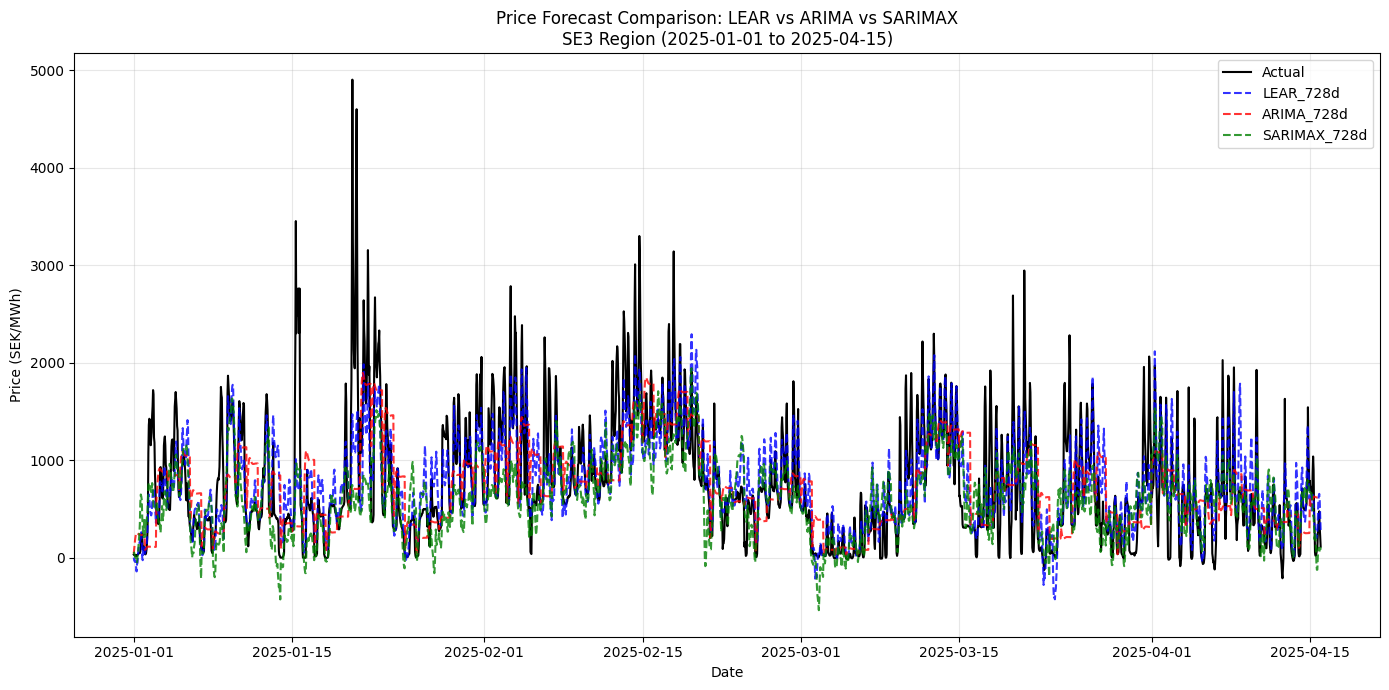


Data Diagnostics:
LEAR missing values: 0/2520
ARIMA missing values: 0/2520
SARIMAX missing values: 0/2520
Actual missing values: 0/2520

Forecast Correlations:
LEAR-ARIMA: 0.6953
LEAR-SARIMAX: 0.7786
ARIMA-SARIMAX: 0.5867


In [9]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 1. Retrieve LEAR forecasts from your environment
lear_fcst = all_forecasts['LEAR_728d']  # From your initial evaluation

# 2. Reconstruct ARIMA forecasts (based on your PDF code page 21)
print("Reconstructing ARIMA forecasts...")
eval_start = pd.Timestamp('2025-01-01', tz='UTC')
eval_end = pd.Timestamp('2025-04-15', tz='UTC')
test_days = pd.date_range(start=eval_start, end=eval_end, freq='D', tz='UTC')
price_series = df_toolbox['Price']

arima_forecasts = []
for day in test_days:
    train_end = day - pd.Timedelta(hours=1)
    train_start = train_end - pd.Timedelta(days=728) + pd.Timedelta(hours=1)
    train_data = price_series.loc[train_start:train_end]
    
    if len(train_data) < 728 * 24:
        arima_forecasts.extend([np.nan] * 24)
        continue
        
    try:
        model = ARIMA(train_data, order=(2,1,2))
        model_fit = model.fit()
        y_pred = model_fit.forecast(steps=24)
    except:
        y_pred = np.full(24, np.nan)
        
    arima_forecasts.extend(y_pred)

# Create ARIMA series with proper datetime index
arima_index = pd.date_range(start=eval_start, end=eval_end + pd.Timedelta(hours=23), freq='H')
arima_fcst = pd.Series(arima_forecasts[:len(arima_index)], index=arima_index, name='ARIMA_728d')

# 3. Reconstruct SARIMAX forecasts
print("Reconstructing SARIMAX forecasts...")
exog_vars = ['Exogenous 1', 'Exogenous 2']
exog_series = df_toolbox[exog_vars]

sarimax_forecasts = []
for day in test_days:
    train_end = day - pd.Timedelta(hours=1)
    train_start = train_end - pd.Timedelta(days=728) + pd.Timedelta(hours=1)
    train_data = price_series.loc[train_start:train_end]
    train_exog = exog_series.loc[train_start:train_end]
    
    if len(train_data) < 728 * 24:
        sarimax_forecasts.extend([np.nan] * 24)
        continue
        
    try:
        model = SARIMAX(train_data, exog=train_exog, order=(1,1,1),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        idx = pd.date_range(day, periods=24, freq='h', tz='UTC')
        exog_forecast = exog_series.loc[idx]
        y_pred = model_fit.forecast(steps=24, exog=exog_forecast)
    except Exception as e:
        print(f"Error on {day.date()}: {e}")
        y_pred = np.full(24, np.nan)
        
    sarimax_forecasts.extend(y_pred)

# Create SARIMAX series with proper datetime index
sarimax_fcst = pd.Series(sarimax_forecasts[:len(arima_index)], index=arima_index, name='SARIMAX_728d')

# 4. Get actual prices
actual = df_toolbox.loc[lear_fcst.index, 'Price']

# 5. Custom Diebold-Mariano test implementation
def custom_dm_test(actual, fcst1, fcst2, horizon=1, power=2):
    """
    Custom implementation of Diebold-Mariano test
    actual: Series of actual values
    fcst1: Series of forecasts from model 1
    fcst2: Series of forecasts from model 2
    horizon: Forecast horizon (default=1)
    power: Power for loss function (1=MAE, 2=MSE)
    """
    # Create aligned DataFrame
    df = pd.DataFrame({
        'actual': actual,
        'fcst1': fcst1,
        'fcst2': fcst2
    }).dropna()
    
    # Calculate errors
    df['e1'] = df['actual'] - df['fcst1']
    df['e2'] = df['actual'] - df['fcst2']
    
    # Calculate loss differential
    df['d'] = np.abs(df['e1'])**power - np.abs(df['e2'])**power
    
    # Calculate mean and variance
    d_bar = df['d'].mean()
    n = len(df)
    
    # Handle insufficient data
    if n < 10:
        return np.nan, np.nan
    
    # Newey-West variance adjustment for autocorrelation
    var_d = df['d'].var(ddof=0)
    for k in range(1, horizon):
        if k < n:
            cov = df['d'].autocorr(lag=k) * var_d
            var_d += 2 * cov * (1 - k/(n-1))
    
    # Calculate DM statistic
    if var_d > 0:
        dm_stat = d_bar / np.sqrt(var_d / n)
        # Two-tailed p-value
        p_value = 2 * (1 - norm.cdf(abs(dm_stat)))
    else:
        dm_stat = np.nan
        p_value = np.nan
    
    return dm_stat, p_value

# 6. Run DM tests
results = []

# LEAR vs ARIMA
dm_stat, p_value = custom_dm_test(actual, lear_fcst, arima_fcst, horizon=1, power=2)
results.append({
    'Model1': 'LEAR_728d',
    'Model2': 'ARIMA_728d',
    'DM_Statistic': dm_stat,
    'P_Value': p_value,
    'Significant (5%)': p_value < 0.05 if not np.isnan(p_value) else False
})

# LEAR vs SARIMAX
dm_stat, p_value = custom_dm_test(actual, lear_fcst, sarimax_fcst, horizon=1, power=2)
results.append({
    'Model1': 'LEAR_728d',
    'Model2': 'SARIMAX_728d',
    'DM_Statistic': dm_stat,
    'P_Value': p_value,
    'Significant (5%)': p_value < 0.05 if not np.isnan(p_value) else False
})

# ARIMA vs SARIMAX
dm_stat, p_value = custom_dm_test(actual, arima_fcst, sarimax_fcst, horizon=1, power=2)
results.append({
    'Model1': 'ARIMA_728d',
    'Model2': 'SARIMAX_728d',
    'DM_Statistic': dm_stat,
    'P_Value': p_value,
    'Significant (5%)': p_value < 0.05 if not np.isnan(p_value) else False
})

# 7. Create and save results
results_df = pd.DataFrame(results)
print("\nDiebold-Mariano Test Results:")
print(results_df)
results_df.to_csv('dm_test_results_final.csv', index=False)

# 8. Visualization
plt.figure(figsize=(14, 7))
plt.plot(actual, 'k-', label='Actual', linewidth=1.5)
plt.plot(lear_fcst, 'b--', label='LEAR_728d', alpha=0.8)
plt.plot(arima_fcst, 'r--', label='ARIMA_728d', alpha=0.8)
plt.plot(sarimax_fcst, 'g--', label='SARIMAX_728d', alpha=0.8)
plt.title('Price Forecast Comparison: LEAR vs ARIMA vs SARIMAX\nSE3 Region (2025-01-01 to 2025-04-15)')
plt.ylabel('Price (SEK/MWh)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('forecast_comparison_dm_test_SE3.png', dpi=300)
plt.show()

# 9. Additional diagnostics
print("\nData Diagnostics:")
print(f"LEAR missing values: {lear_fcst.isna().sum()}/{len(lear_fcst)}")
print(f"ARIMA missing values: {arima_fcst.isna().sum()}/{len(arima_fcst)}")
print(f"SARIMAX missing values: {sarimax_fcst.isna().sum()}/{len(sarimax_fcst)}")
print(f"Actual missing values: {actual.isna().sum()}/{len(actual)}")

# Correlation between forecasts
print("\nForecast Correlations:")
print(f"LEAR-ARIMA: {lear_fcst.corr(arima_fcst):.4f}")
print(f"LEAR-SARIMAX: {lear_fcst.corr(sarimax_fcst):.4f}")
print(f"ARIMA-SARIMAX: {arima_fcst.corr(sarimax_fcst):.4f}")

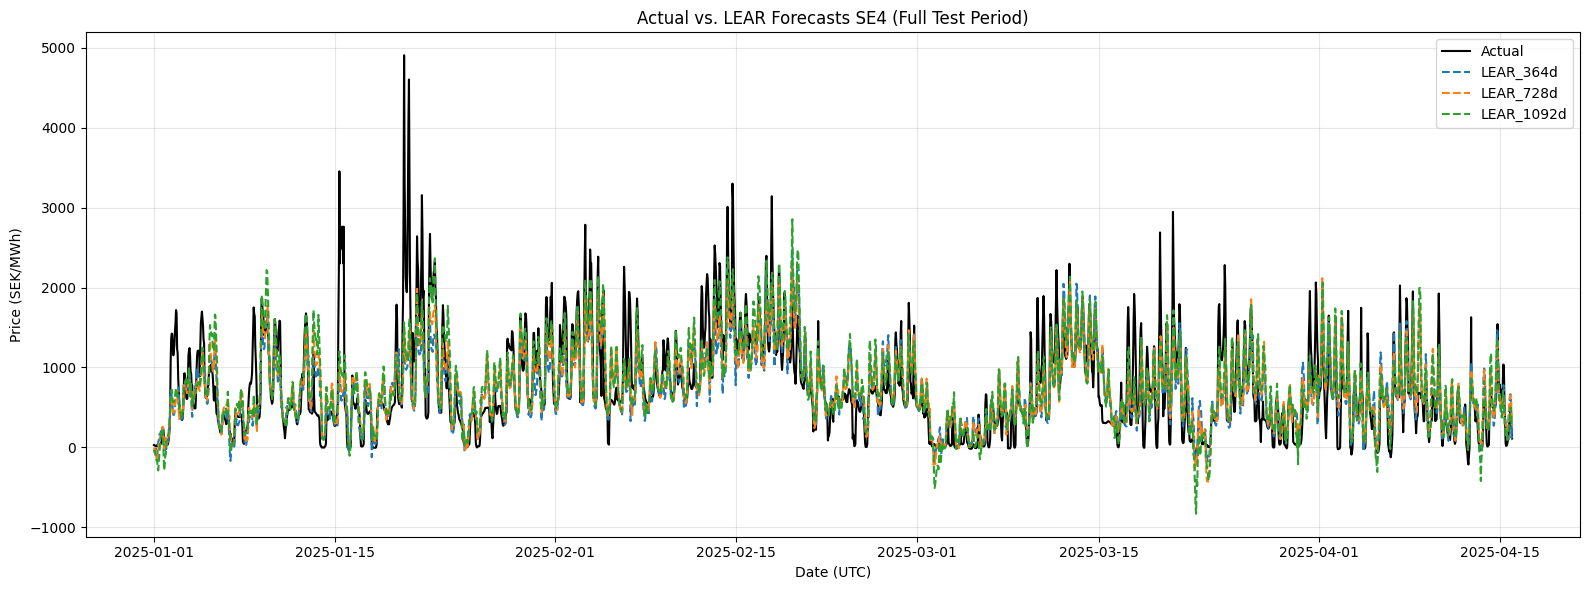

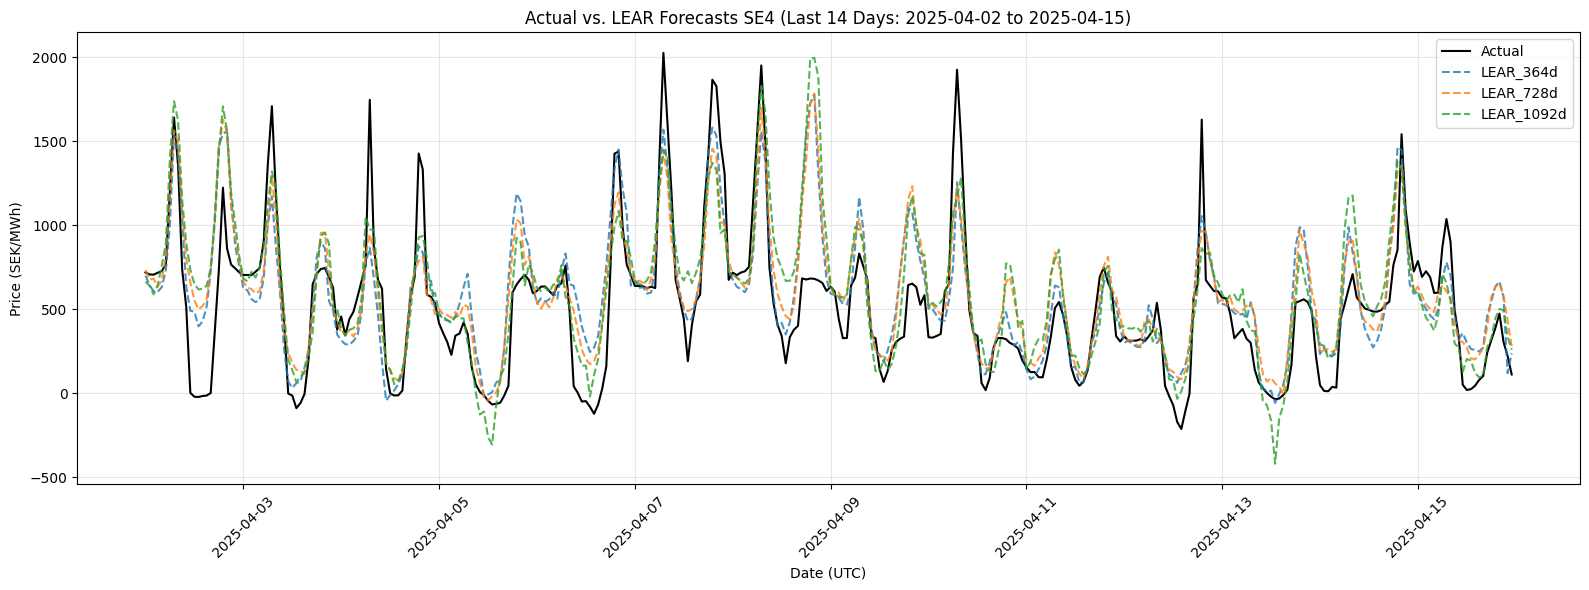

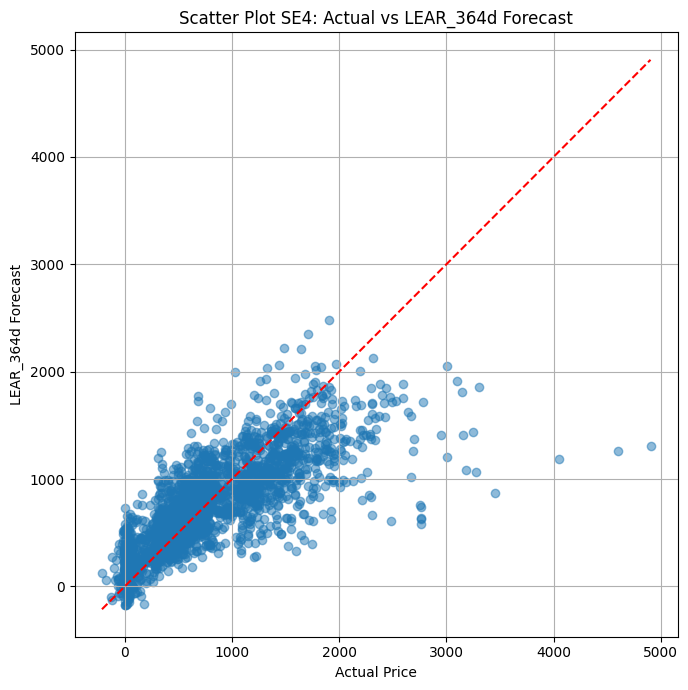

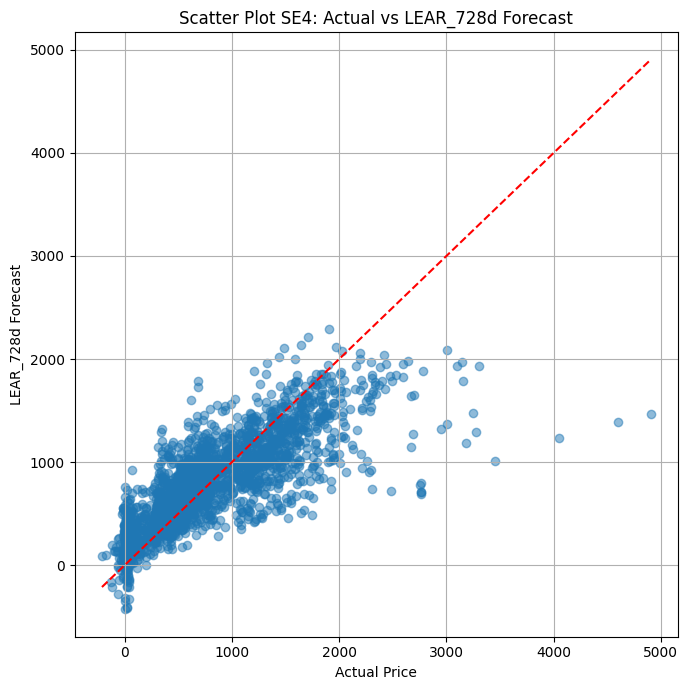

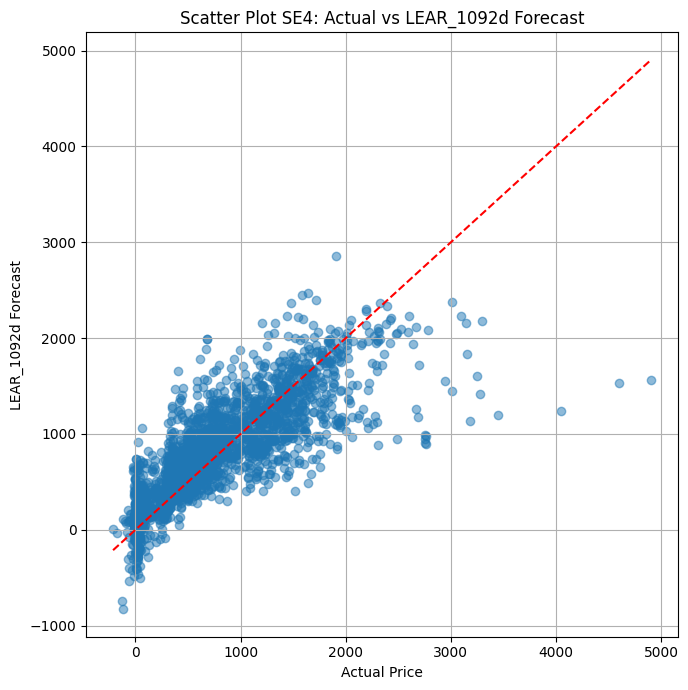

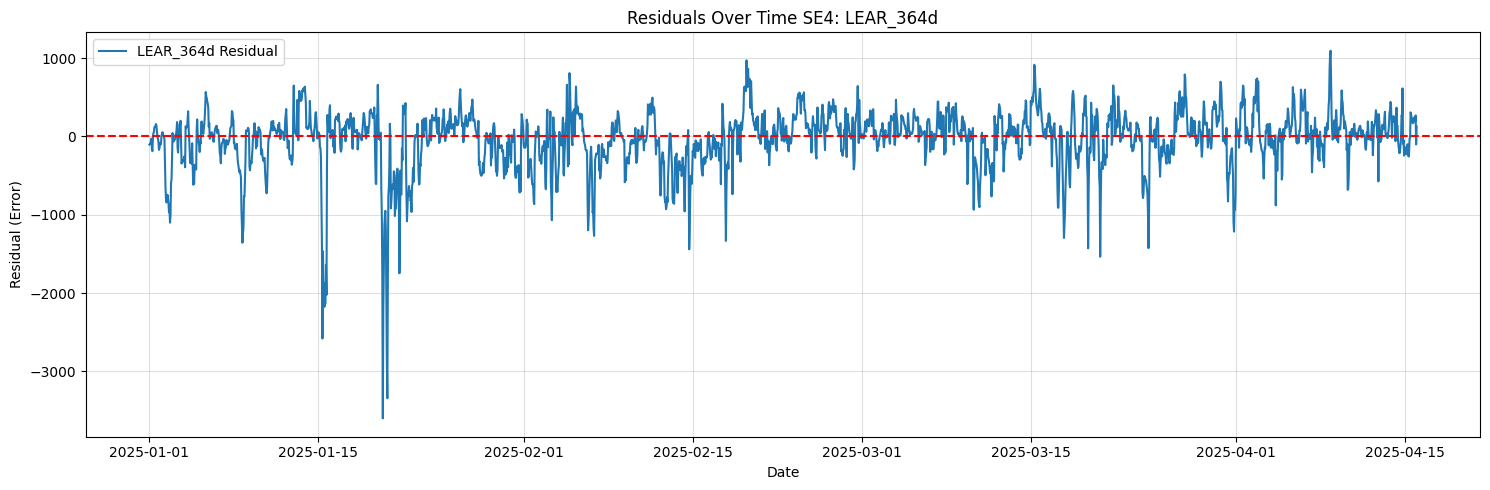

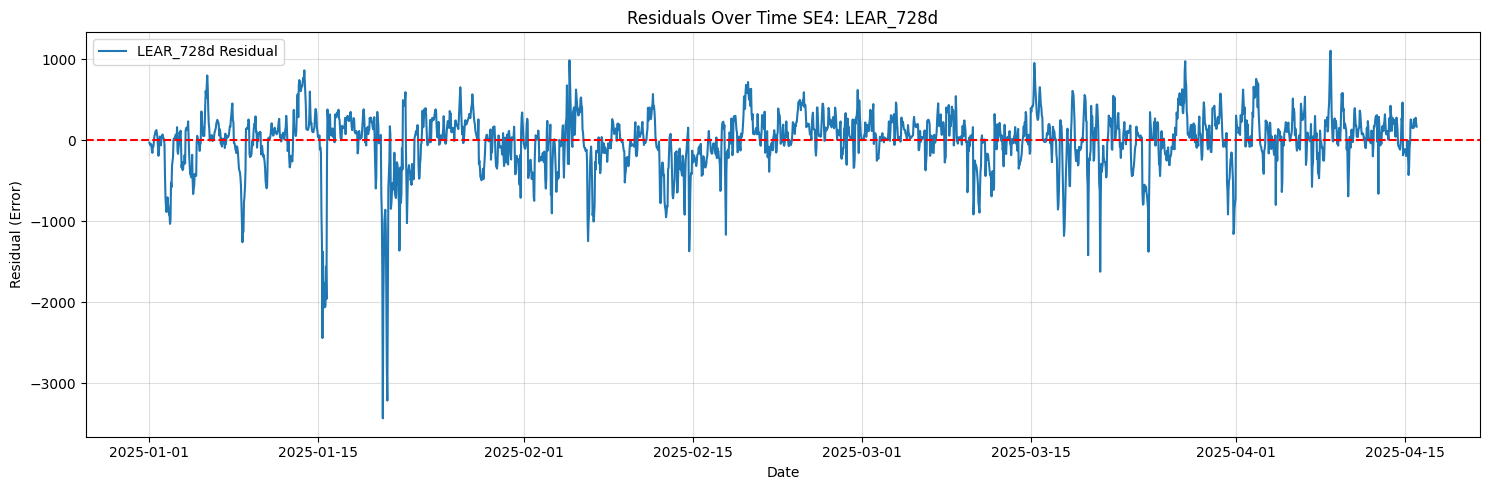

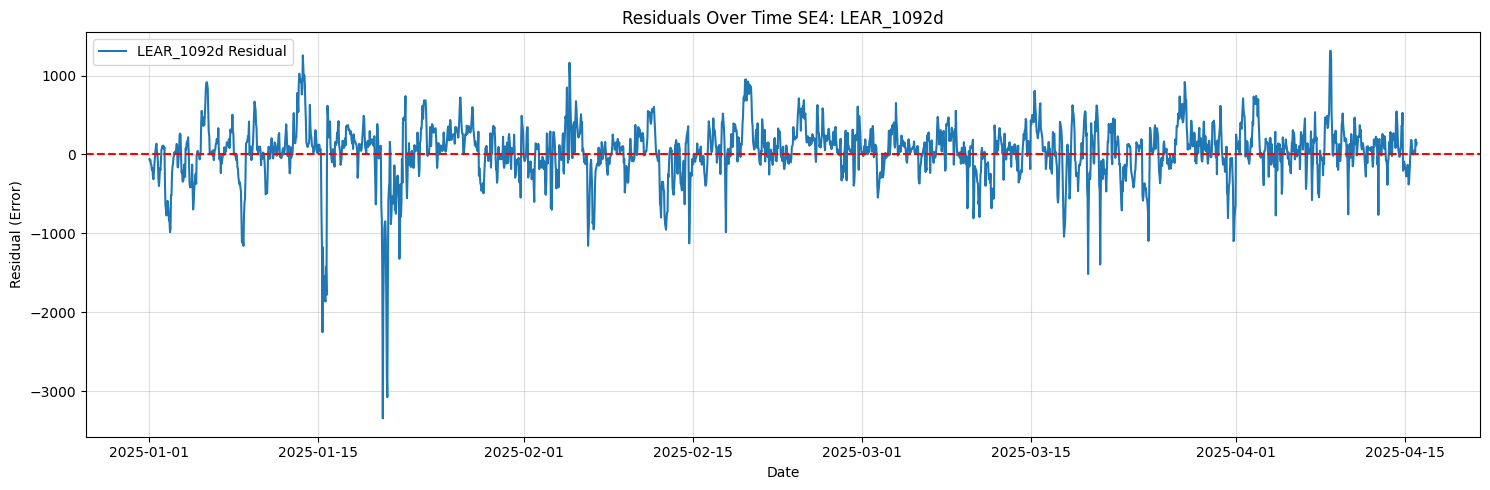

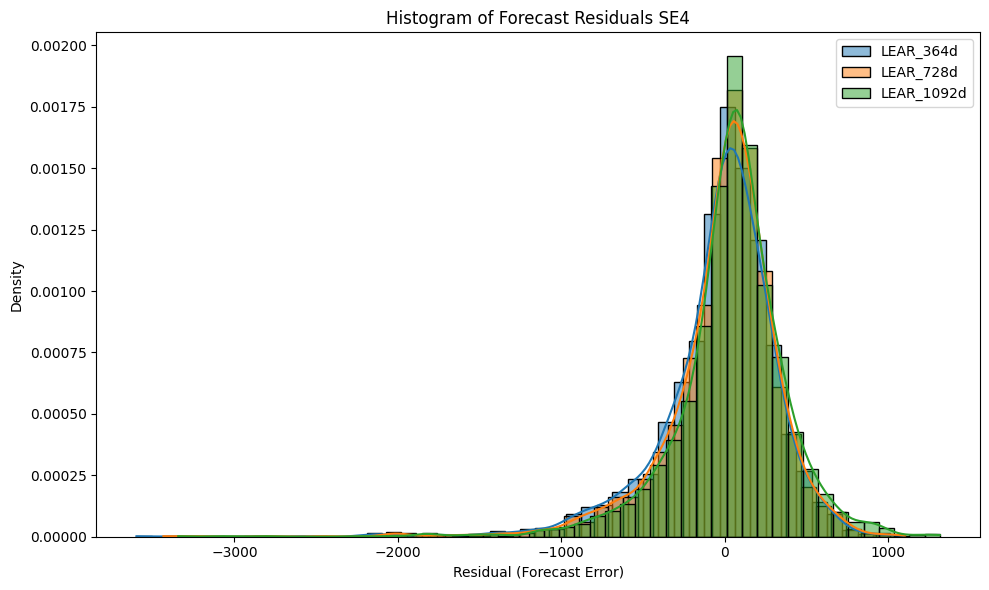

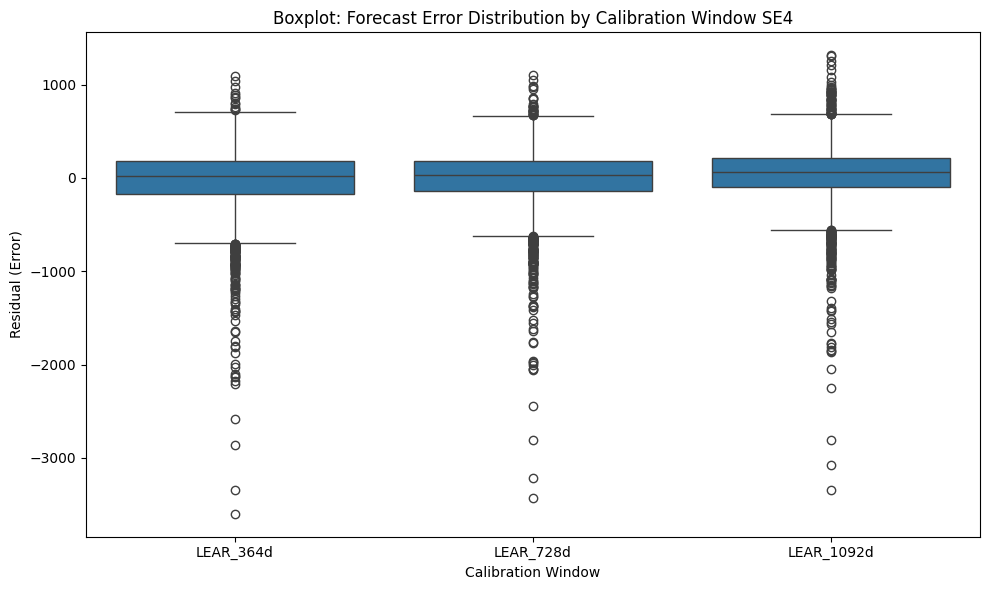

In [7]:
import seaborn as sns

# Helper to get actual for plot period
def get_actual(start, end):
    return df_toolbox.loc[start:end, 'Price']

# 1. Actual vs. Forecasted Prices (all windows, full test period)
plt.figure(figsize=(16, 6))
actual = get_actual(eval_start, eval_end + pd.Timedelta(hours=23))
plt.plot(actual.index, actual, label='Actual', color='black')
for name, forecast in all_forecasts.items():
    plt.plot(forecast.index, forecast, '--', label=name)
plt.title('Actual vs. LEAR Forecasts SE4 (Full Test Period)')
plt.ylabel('Price (SEK/MWh)')
plt.xlabel('Date (UTC)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================================================================
# 2. Zoom-in: LAST 14 days of test period
# ==============================================================================
plt.figure(figsize=(16, 6))

# Calculate last 14 days range
last_14_start = eval_end - pd.Timedelta(days=13)  # 14 days inclusive
last_14_end = eval_end + pd.Timedelta(hours=23)   # Include last full day

# Get actual data for the period
actual_last14 = df_toolbox.loc[last_14_start:last_14_end, 'Price']

# Plot actual
plt.plot(actual_last14.index, actual_last14, 
         label='Actual', 
         color='black',
         linewidth=1.5)

# Plot all forecasts
for name, forecast in all_forecasts.items():
    plt.plot(forecast.loc[last_14_start:last_14_end].index, 
             forecast.loc[last_14_start:last_14_end], 
             '--', 
             label=name,
             alpha=0.8)

plt.title(f'Actual vs. LEAR Forecasts SE4 (Last 14 Days: {last_14_start.date()} to {last_14_end.date()})')
plt.ylabel('Price (SEK/MWh)')
plt.xlabel('Date (UTC)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis to show dates properly
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plt.savefig('last_14_days_forecast SE4.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Scatter Plot: Actual vs Forecast (per window)
for name, forecast in all_forecasts.items():
    valid = (~forecast.isna()) & (~actual.isna())
    plt.figure(figsize=(7,7))
    plt.scatter(actual[valid], forecast[valid], alpha=0.5)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
    plt.title(f'Scatter Plot SE4: Actual vs {name} Forecast')
    plt.xlabel('Actual Price')
    plt.ylabel(f'{name} Forecast')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 4. Residual Plot: Error vs Time (per window)
for name, forecast in all_forecasts.items():
    residual = forecast - actual
    plt.figure(figsize=(15,5))
    plt.plot(residual.index, residual, label=f'{name} Residual')
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f'Residuals Over Time SE4: {name}')
    plt.xlabel('Date')
    plt.ylabel('Residual (Error)')
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 5. Histogram of Residuals (per window)
plt.figure(figsize=(10,6))
for name, forecast in all_forecasts.items():
    residual = forecast - actual
    sns.histplot(residual.dropna(), label=name, kde=True, stat="density", bins=50, alpha=0.5)
plt.title('Histogram of Forecast Residuals SE4')
plt.xlabel('Residual (Forecast Error)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Boxplot: Forecast Error Distribution Across Windows
errors = []
for name, forecast in all_forecasts.items():
    residual = (forecast - actual).dropna()
    errors.append(pd.DataFrame({'Residual': residual, 'Model': name}))
errors_df = pd.concat(errors)
plt.figure(figsize=(10,6))
sns.boxplot(x='Model', y='Residual', data=errors_df)
plt.title('Boxplot: Forecast Error Distribution by Calibration Window SE4')
plt.xlabel('Calibration Window')
plt.ylabel('Residual (Error)')
plt.tight_layout()
plt.show()


--- [1/4] Loading and Preparing Data ---
Memory usage: 77.4% (Free: 1.86GB)
Ensuring continuous data...
Converting to UTC...
Running LEAR model for 728 days (NetLoad+Temp)


LEAR 728d Progress: 100%|██████████| 105/105 [11:48<00:00,  6.75s/it]



--- Constructing 80% Prediction Interval (Quantile-Based) ---

Prediction Interval Coverage (PICP): 79.05%


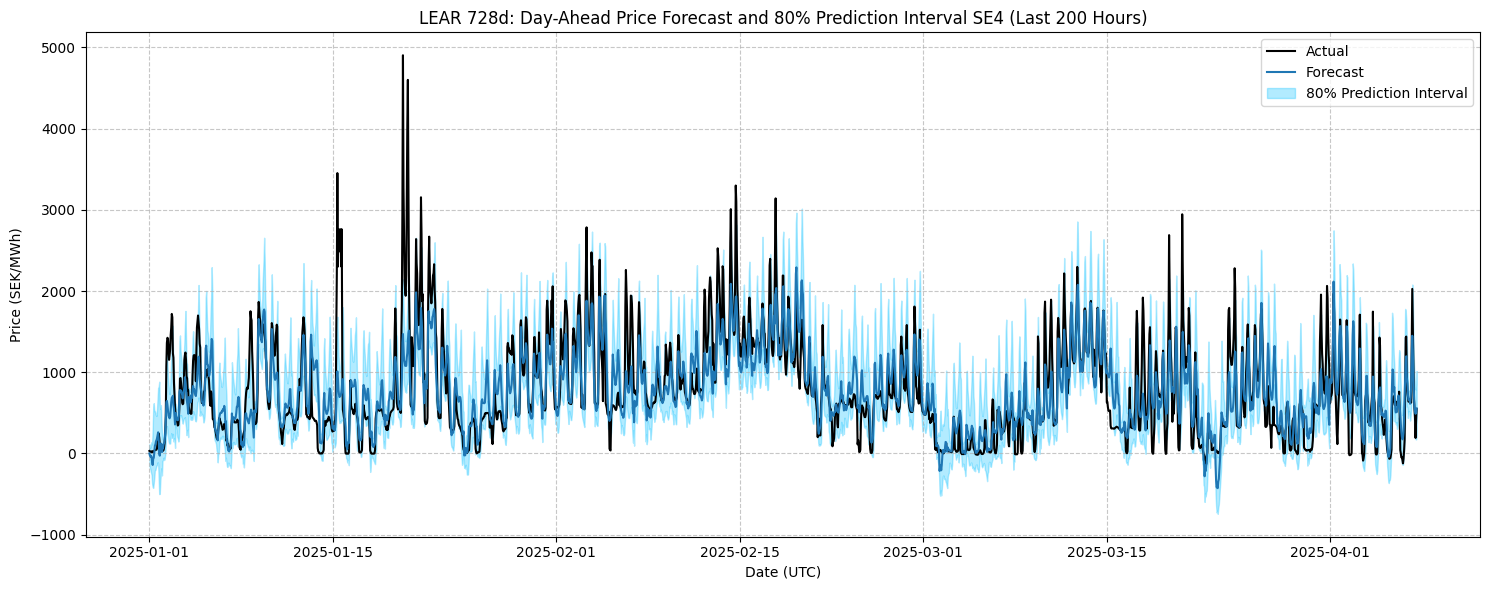


--- Script Completed ---


In [9]:
# ======================================================================
# 1. Imports and Environment Setup
# ======================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from epftoolbox.models import LEAR
from epftoolbox.evaluation import MAE, sMAPE, RMSE
import warnings, os, logging, psutil, traceback, time
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def check_memory():
    mem = psutil.virtual_memory()
    print(f"Memory usage: {mem.percent}% (Free: {mem.available/1e9:.2f}GB)")

def clean_column_names(df):
    df.columns = [str(c).replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]
    rename_map = {
        'Nord_Pool_Spot_Price_SE3_SEK_MWh': 'Price',
        'Consumption_SE3_MWh': 'Consumption',
        'Production_SE3_MWh': 'Production',
        'Temperature': 'Temperature'
    }
    for k in list(rename_map.keys()):
        if k not in df.columns:
            del rename_map[k]
    return df.rename(columns=rename_map)

def handle_dst_transitions(df):
    """Ensure data is continuous over DST transitions by interpolating missing hours."""
    df = df[~df.index.duplicated(keep='first')]
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
    df = df.reindex(full_index)
    return df.interpolate(method='time')

# ======================================================================
# 2. Main Script: Data Preparation and LEAR Model Forecasting
# ======================================================================
try:
    # ----- Load and Prepare Data -----
    print("--- [1/4] Loading and Preparing Data ---")
    check_memory()
    FILE_PATH = 'C:/Users/dines/datasets/nordpool_se4_with_temperature.csv'  # <-- CHANGE PATH if needed
    df = pd.read_csv(FILE_PATH, index_col=0, parse_dates=True)
    df.index.name = 'Datetime'

    # Clean columns, create NetLoad, subset to necessary columns
    df = clean_column_names(df)
    df['NetLoad'] = df['Consumption'] - df['Production']
    exog_vars = ['NetLoad']
    if 'Temperature' in df.columns:
        exog_vars.append('Temperature')
    use_cols = ['Price'] + exog_vars
    df = df[use_cols].copy()

    print("Ensuring continuous data...")
    df = handle_dst_transitions(df)
    print("Converting to UTC...")
    if df.index.tz is None:
        df = df.tz_localize('UTC', ambiguous='NaT', nonexistent='shift_forward')
    else:
        df = df.tz_convert('UTC')
    df = df.dropna()

    # Rename exogenous columns for epftoolbox
    exog_map = {'NetLoad': 'Exogenous 1'}
    if 'Temperature' in exog_vars:
        exog_map['Temperature'] = 'Exogenous 2'
    df_toolbox = df.rename(columns=exog_map)

    # ----- Set evaluation period -----
    eval_start = pd.Timestamp('2025-01-01', tz='UTC')
    eval_end = pd.Timestamp('2025-04-15', tz='UTC')
    p_in_sample = df_toolbox.loc[:eval_start - pd.Timedelta(hours=1), 'Price']

    # ----- LEAR Model Forecasting (728-day window) -----
    calibration_days = 728
    print(f"Running LEAR model for {calibration_days} days (NetLoad+Temp)")

    daily_forecasts = []
    test_days = pd.date_range(start=eval_start, end=eval_end, freq='D', tz='UTC')
    for day in tqdm(test_days, desc="LEAR 728d Progress"):
        try:
            model = LEAR()
            pred = model.recalibrate_and_forecast_next_day(
                df=df_toolbox,
                next_day_date=day,
                calibration_window=calibration_days
            )
            pred = np.array(pred).flatten()
            if len(pred) == 0:
                raise ValueError("Empty prediction array")
            elif len(pred) == 1:
                pred = np.full(24, pred[0])
            elif len(pred) < 24:
                last_val = pred[-1]
                pred = np.pad(pred, (0, 24-len(pred)), 'constant', constant_values=last_val)
            elif len(pred) > 24:
                pred = pred[:24]
            idx = pd.date_range(start=day, periods=24, freq='h', tz='UTC')
            forecast_series = pd.Series(pred, index=idx, name='Forecast', dtype=float)
            daily_forecasts.append(forecast_series)
        except Exception as e:
            print(f"\nError on {day.date()}: {str(e)}")
            traceback.print_exc()

    # Concatenate all daily forecasts into a single Series
    forecast = pd.concat(daily_forecasts)
    actual = df_toolbox.loc[forecast.index, 'Price']

    # =====================================================================
    # 3. Probabilistic Forecasting: 80% Prediction Interval (Empirical Quantiles)
    # =====================================================================
    print("\n--- Constructing 80% Prediction Interval (Quantile-Based) ---")
    residuals = actual - forecast

    # Group residuals by hour of the day
    residuals_by_hour = {h: residuals[residuals.index.hour == h] for h in range(24)}
    quantiles = {h: (np.quantile(r.dropna(), 0.10), np.quantile(r.dropna(), 0.90))
                 for h, r in residuals_by_hour.items()}

    pi_lower, pi_upper = [], []
    for ts in forecast.index:
        hour = ts.hour
        q10, q90 = quantiles[hour]
        pi_lower.append(forecast[ts] + q10)
        pi_upper.append(forecast[ts] + q90)

    # Final DataFrame
    results_df = pd.DataFrame({
        'Actual': actual,
        'Forecast': forecast,
        'PI Lower (80%)': pi_lower,
        'PI Upper (80%)': pi_upper
    })

    # PICP calculation (Prediction Interval Coverage Probability)
    within_pi = (results_df['Actual'] >= results_df['PI Lower (80%)']) & (results_df['Actual'] <= results_df['PI Upper (80%)'])
    picp = np.mean(within_pi)
    print(f"\nPrediction Interval Coverage (PICP): {picp * 100:.2f}%")

    # =====================================================================
    # 4. Visualization
    # =====================================================================
    plot_slice = results_df.iloc[:-200]
    plt.figure(figsize=(15, 6))
    plt.plot(plot_slice.index, plot_slice['Actual'], label='Actual', color='black', lw=1.5)
    plt.plot(plot_slice.index, plot_slice['Forecast'], label='Forecast', color='tab:blue', lw=1.5)
    plt.fill_between(plot_slice.index, plot_slice['PI Lower (80%)'], plot_slice['PI Upper (80%)'],
                     color='deepskyblue', alpha=0.3, label='80% Prediction Interval')
    plt.title('LEAR 728d: Day-Ahead Price Forecast and 80% Prediction Interval SE4 (Last 200 Hours)')
    plt.xlabel('Date (UTC)')
    plt.ylabel('Price (SEK/MWh)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nFATAL ERROR: {str(e)}")
    traceback.print_exc()

finally:
    print("\n--- Script Completed ---")


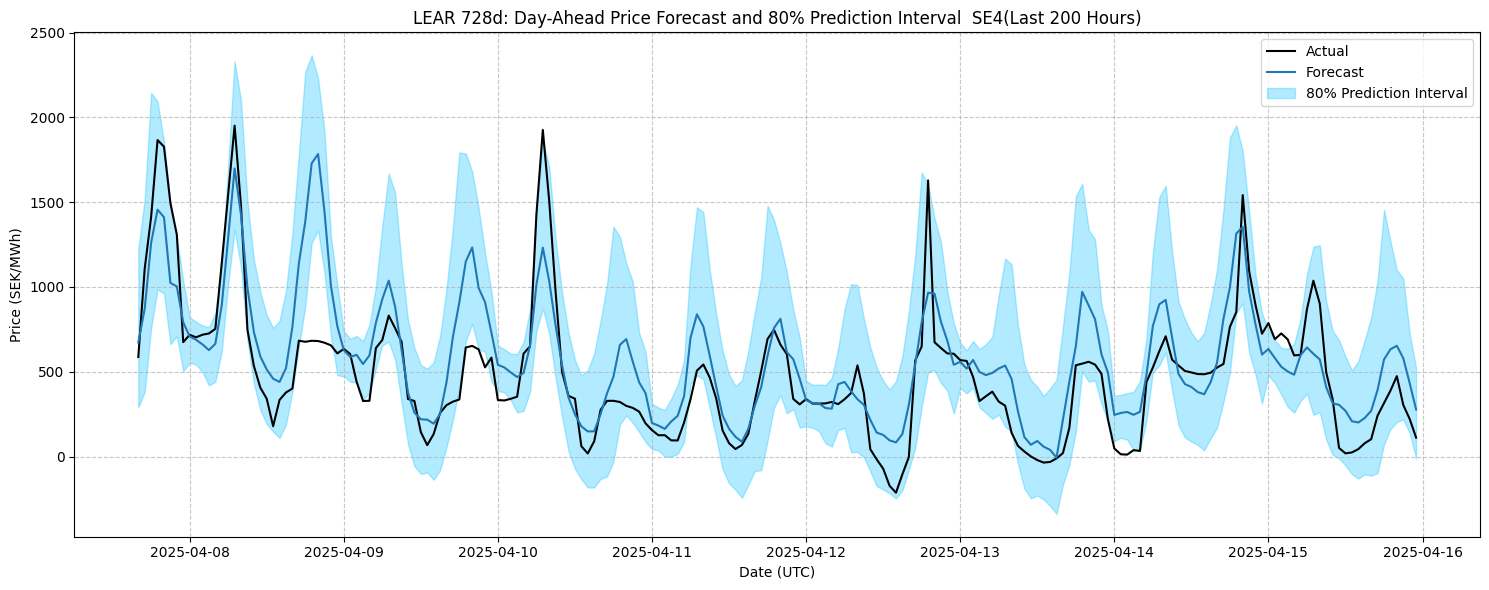

In [11]:
plot_slice = results_df.iloc[-200:]

plt.figure(figsize=(15, 6))
plt.plot(plot_slice.index, plot_slice['Actual'], label='Actual', color='black', lw=1.5)
plt.plot(plot_slice.index, plot_slice['Forecast'], label='Forecast', color='tab:blue', lw=1.5)
plt.fill_between(plot_slice.index, plot_slice['PI Lower (80%)'], plot_slice['PI Upper (80%)'],
                 color='deepskyblue', alpha=0.3, label='80% Prediction Interval')

plt.title('LEAR 728d: Day-Ahead Price Forecast and 80% Prediction Interval  SE4(Last 200 Hours)')
plt.xlabel('Date (UTC)')
plt.ylabel('Price (SEK/MWh)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Reconstructing ARIMA forecasts...
Reconstructing SARIMAX forecasts...
Error on 2025-01-01: name 'SARIMAX' is not defined
Error on 2025-01-02: name 'SARIMAX' is not defined
Error on 2025-01-03: name 'SARIMAX' is not defined
Error on 2025-01-04: name 'SARIMAX' is not defined
Error on 2025-01-05: name 'SARIMAX' is not defined
Error on 2025-01-06: name 'SARIMAX' is not defined
Error on 2025-01-07: name 'SARIMAX' is not defined
Error on 2025-01-08: name 'SARIMAX' is not defined
Error on 2025-01-09: name 'SARIMAX' is not defined
Error on 2025-01-10: name 'SARIMAX' is not defined
Error on 2025-01-11: name 'SARIMAX' is not defined
Error on 2025-01-12: name 'SARIMAX' is not defined
Error on 2025-01-13: name 'SARIMAX' is not defined
Error on 2025-01-14: name 'SARIMAX' is not defined
Error on 2025-01-15: name 'SARIMAX' is not defined
Error on 2025-01-16: name 'SARIMAX' is not defined
Error on 2025-01-17: name 'SARIMAX' is not defined
Error on 2025-01-18: name 'SARIMAX' is not defined
Error on 202

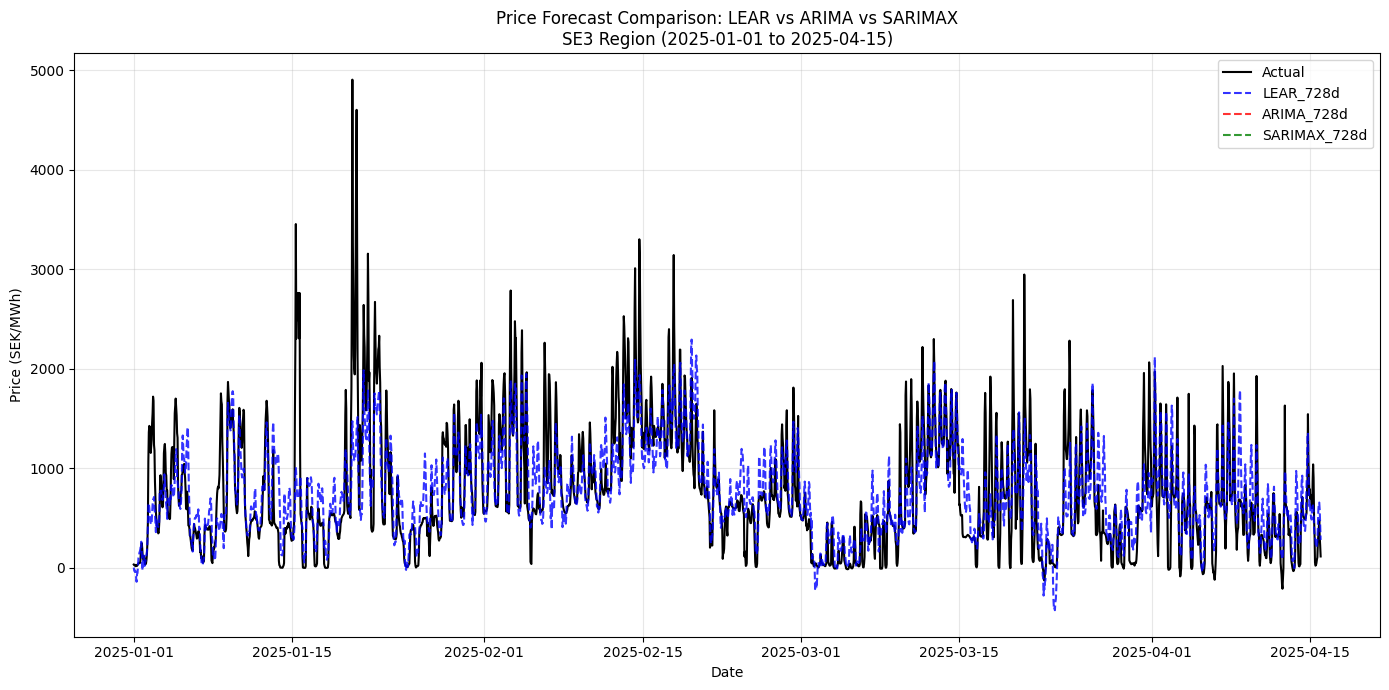


Data Diagnostics:
LEAR missing values: 0/2520
ARIMA missing values: 2520/2520
SARIMAX missing values: 2520/2520
Actual missing values: 0/2520

Forecast Correlations:
LEAR-ARIMA: nan
LEAR-SARIMAX: nan
ARIMA-SARIMAX: nan


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 1. Retrieve LEAR forecasts from your environment
lear_fcst = all_forecasts['LEAR_728d']  # From your initial evaluation

# 2. Reconstruct ARIMA forecasts (based on your PDF code page 21)
print("Reconstructing ARIMA forecasts...")
eval_start = pd.Timestamp('2025-01-01', tz='UTC')
eval_end = pd.Timestamp('2025-04-15', tz='UTC')
test_days = pd.date_range(start=eval_start, end=eval_end, freq='D', tz='UTC')
price_series = df_toolbox['Price']

arima_forecasts = []
for day in test_days:
    train_end = day - pd.Timedelta(hours=1)
    train_start = train_end - pd.Timedelta(days=728) + pd.Timedelta(hours=1)
    train_data = price_series.loc[train_start:train_end]
    
    if len(train_data) < 728 * 24:
        arima_forecasts.extend([np.nan] * 24)
        continue
        
    try:
        model = ARIMA(train_data, order=(2,1,2))
        model_fit = model.fit()
        y_pred = model_fit.forecast(steps=24)
    except:
        y_pred = np.full(24, np.nan)
        
    arima_forecasts.extend(y_pred)

# Create ARIMA series with proper datetime index
arima_index = pd.date_range(start=eval_start, end=eval_end + pd.Timedelta(hours=23), freq='H')
arima_fcst = pd.Series(arima_forecasts[:len(arima_index)], index=arima_index, name='ARIMA_728d')

# 3. Reconstruct SARIMAX forecasts (based on your PDF code page 23)
print("Reconstructing SARIMAX forecasts...")
exog_vars = ['Exogenous 1', 'Exogenous 2']
exog_series = df_toolbox[exog_vars]

sarimax_forecasts = []
for day in test_days:
    train_end = day - pd.Timedelta(hours=1)
    train_start = train_end - pd.Timedelta(days=728) + pd.Timedelta(hours=1)
    train_data = price_series.loc[train_start:train_end]
    train_exog = exog_series.loc[train_start:train_end]
    
    if len(train_data) < 728 * 24:
        sarimax_forecasts.extend([np.nan] * 24)
        continue
        
    try:
        model = SARIMAX(train_data, exog=train_exog, order=(1,1,1),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        idx = pd.date_range(day, periods=24, freq='h', tz='UTC')
        exog_forecast = exog_series.loc[idx]
        y_pred = model_fit.forecast(steps=24, exog=exog_forecast)
    except Exception as e:
        print(f"Error on {day.date()}: {e}")
        y_pred = np.full(24, np.nan)
        
    sarimax_forecasts.extend(y_pred)

# Create SARIMAX series with proper datetime index
sarimax_fcst = pd.Series(sarimax_forecasts[:len(arima_index)], index=arima_index, name='SARIMAX_728d')

# 4. Get actual prices
actual = df_toolbox.loc[lear_fcst.index, 'Price']

# 5. Custom Diebold-Mariano test implementation
def custom_dm_test(actual, fcst1, fcst2, horizon=1, power=2):
    """
    Custom implementation of Diebold-Mariano test
    actual: Series of actual values
    fcst1: Series of forecasts from model 1
    fcst2: Series of forecasts from model 2
    horizon: Forecast horizon (default=1)
    power: Power for loss function (1=MAE, 2=MSE)
    """
    # Create aligned DataFrame
    df = pd.DataFrame({
        'actual': actual,
        'fcst1': fcst1,
        'fcst2': fcst2
    }).dropna()
    
    # Calculate errors
    df['e1'] = df['actual'] - df['fcst1']
    df['e2'] = df['actual'] - df['fcst2']
    
    # Calculate loss differential
    df['d'] = np.abs(df['e1'])**power - np.abs(df['e2'])**power
    
    # Calculate mean and variance
    d_bar = df['d'].mean()
    n = len(df)
    
    # Handle insufficient data
    if n < 10:
        return np.nan, np.nan
    
    # Newey-West variance adjustment for autocorrelation
    var_d = df['d'].var(ddof=0)
    for k in range(1, horizon):
        if k < n:
            cov = df['d'].autocorr(lag=k) * var_d
            var_d += 2 * cov * (1 - k/(n-1))
    
    # Calculate DM statistic
    if var_d > 0:
        dm_stat = d_bar / np.sqrt(var_d / n)
        # Two-tailed p-value
        p_value = 2 * (1 - norm.cdf(abs(dm_stat)))
    else:
        dm_stat = np.nan
        p_value = np.nan
    
    return dm_stat, p_value

# 6. Run DM tests
results = []

# LEAR vs ARIMA
dm_stat, p_value = custom_dm_test(actual, lear_fcst, arima_fcst, horizon=1, power=2)
results.append({
    'Model1': 'LEAR_728d',
    'Model2': 'ARIMA_728d',
    'DM_Statistic': dm_stat,
    'P_Value': p_value,
    'Significant (5%)': p_value < 0.05 if not np.isnan(p_value) else False
})

# LEAR vs SARIMAX
dm_stat, p_value = custom_dm_test(actual, lear_fcst, sarimax_fcst, horizon=1, power=2)
results.append({
    'Model1': 'LEAR_728d',
    'Model2': 'SARIMAX_728d',
    'DM_Statistic': dm_stat,
    'P_Value': p_value,
    'Significant (5%)': p_value < 0.05 if not np.isnan(p_value) else False
})

# ARIMA vs SARIMAX
dm_stat, p_value = custom_dm_test(actual, arima_fcst, sarimax_fcst, horizon=1, power=2)
results.append({
    'Model1': 'ARIMA_728d',
    'Model2': 'SARIMAX_728d',
    'DM_Statistic': dm_stat,
    'P_Value': p_value,
    'Significant (5%)': p_value < 0.05 if not np.isnan(p_value) else False
})

# 7. Create and save results
results_df = pd.DataFrame(results)
print("\nDiebold-Mariano Test Results:")
print(results_df)
results_df.to_csv('dm_test_results_final.csv', index=False)

# 8. Visualization
plt.figure(figsize=(14, 7))
plt.plot(actual, 'k-', label='Actual', linewidth=1.5)
plt.plot(lear_fcst, 'b--', label='LEAR_728d', alpha=0.8)
plt.plot(arima_fcst, 'r--', label='ARIMA_728d', alpha=0.8)
plt.plot(sarimax_fcst, 'g--', label='SARIMAX_728d', alpha=0.8)
plt.title('Price Forecast Comparison: LEAR vs ARIMA vs SARIMAX\nSE3 Region (2025-01-01 to 2025-04-15)')
plt.ylabel('Price (SEK/MWh)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('forecast_comparison_dm_test_SE3.png', dpi=300)
plt.show()

# 9. Additional diagnostics
print("\nData Diagnostics:")
print(f"LEAR missing values: {lear_fcst.isna().sum()}/{len(lear_fcst)}")
print(f"ARIMA missing values: {arima_fcst.isna().sum()}/{len(arima_fcst)}")
print(f"SARIMAX missing values: {sarimax_fcst.isna().sum()}/{len(sarimax_fcst)}")
print(f"Actual missing values: {actual.isna().sum()}/{len(actual)}")

# Correlation between forecasts
print("\nForecast Correlations:")
print(f"LEAR-ARIMA: {lear_fcst.corr(arima_fcst):.4f}")
print(f"LEAR-SARIMAX: {lear_fcst.corr(sarimax_fcst):.4f}")
print(f"ARIMA-SARIMAX: {arima_fcst.corr(sarimax_fcst):.4f}")